In [1]:
import sys

sys.path.insert(0, "../../scripts")
import estimators

In [2]:
%matplotlib widget
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

df = Table(fits.open("../../data/TESS_fast-rotators/tess-ultra-fast-rotators-brighter-mag14.fits")[1].data)

## Loading data

In [3]:
import lightkurve as lk

# e.g TOI-540,
# name = "TIC 246855533"
i = 0
name = f"TIC {df['Name'][i]}"
period = df['LS_Period'][i]

search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)
print(name)
search_result

TIC 70775324


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,70775324,0.0
1,TESS Sector 29,2020,SPOC,120,70775324,0.0


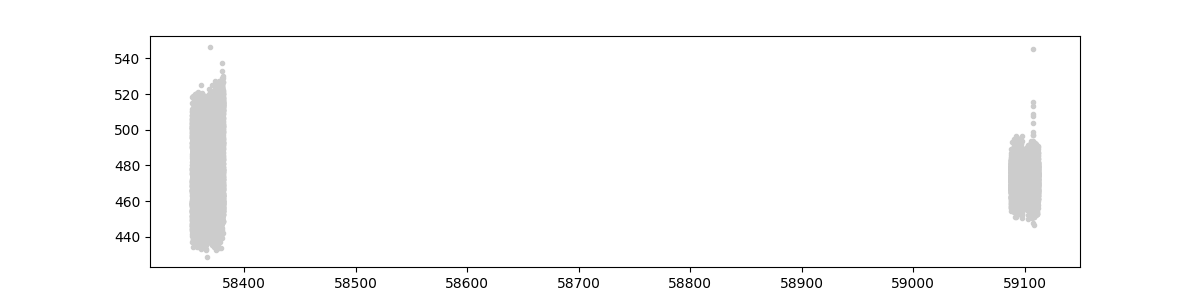

In [4]:
# data
klc = [search_result[i].download() for i in range(2)]
#klc = search_result.download_all()
times = [k.time.to_value('mjd') for k in klc]
fluxes = [k.pdcsap_flux.to_value().filled(np.nan) for k in klc]
errors = [k.flux_err.to_value().filled(np.nan) for k in klc]
masks = [np.isnan(f) | np.isnan(e) | np.isnan(t) for f, e, t in zip(fluxes, errors, times)]

# masking
times = [t[~m] for t, m in zip(times, masks)]
time = np.hstack(times)
original_flux = np.hstack([f[~m] for f, m in zip(fluxes, masks)])
original_error = np.hstack([e[~m] for e, m in zip(errors, masks)])

plt.figure(None, (12, 3))
plt.plot(time, original_flux, ".", c="0.8")

## First linear detrending

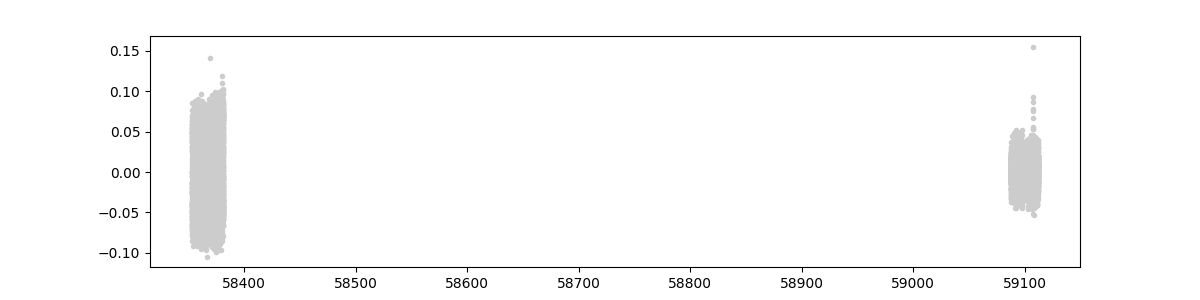

In [5]:
from scipy.linalg import block_diag

X = block_diag(*[(t**np.arange(0, 2)[:, None]).T for t in times]).T
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

w = np.linalg.lstsq(X.T, original_flux, rcond=None)[0]

flux = (original_flux / (w@X)) - 1.
error = (original_error / (w@X))

plt.figure(None, (12, 3))
plt.plot(time, flux, ".", c="0.8")
#plt.plot(w@X)

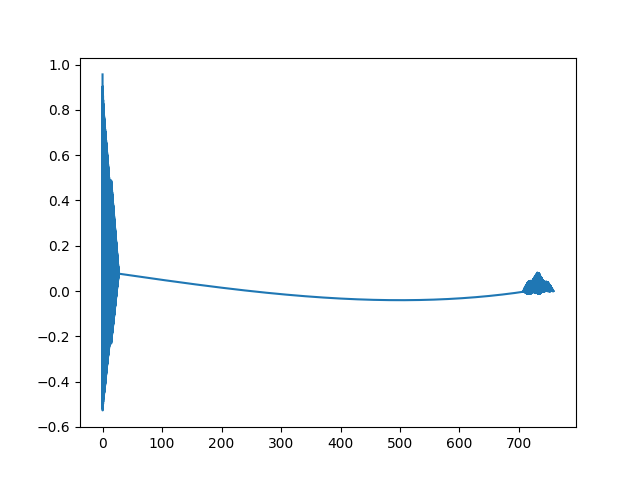

In [6]:
acor = estimators.autocorr_estimator(time, flux)

lag, power = acor["autocorr"]
plt.figure()
plt.plot(lag, power)

## Designing the GP

In [7]:
from tinygp import kernels
import jax

jax.config.update("jax_enable_x64", True)

def plot_kernel(kernel, **kwargs):
    k = kernel(lag, lag[:1])
    plt.plot(lag, k/k[0], **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

In [8]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess

def build_gp(params, X):
    
    alpha = 1 #jnp.exp(params["log_alpha"])
    short = kernels.quasisep.Matern32(sigma=jnp.exp(params["log_sigma_short"]), scale=alpha*jnp.exp(params["log_scale_short"]))
    long = kernels.quasisep.Matern32(sigma=jnp.exp(params["log_sigma_long"]), scale=alpha*jnp.exp(params["log_scale_long"]))
    periodic = kernels.quasisep.SHO(omega=jnp.exp(params["log_omega"]), quality=jnp.exp(params["log_quality"]), sigma=alpha*jnp.exp(params["log_sigma"]))
    
    kernel = periodic + short + long
    
    return GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean=params["mean"])

## Optimization

In [9]:
import jaxopt

@jax.jit
def neg_log_likelihood(params, X, y):
    gp = build_gp(params, X)
    return -gp.log_probability(y)

@jax.jit
def condition(y=None, x=None):
    cond_gp = gp.condition(y, x).gp
    return cond_gp.loc

def optimize_subset(init_params, X, y, param_names=None):
    def inner(theta, *args, **kwargs):
        params = dict(init_params, **theta)
        return neg_log_likelihood(params, *args, **kwargs)

    param_names = list(init_params.keys()) if param_names is None else param_names
    start = {k: init_params[k] for k in param_names}

    solver = jaxopt.ScipyMinimize(fun=inner)
    soln = solver.run(start, X=X, y=y)
    print(soln.state)

    return dict(init_params, **soln.params)

-43069.69332442886


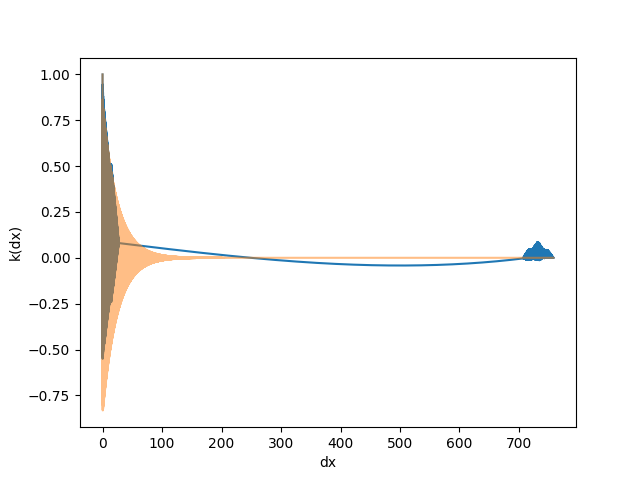

In [10]:
init_params = {
    "log_sigma_short": jnp.log(1e-1),
    "log_scale_short": jnp.log(1e-4),
    "log_sigma_long": jnp.log(1e-1),
    "log_scale_long": jnp.log(1.7e-1),
    "log_omega": jnp.log(2 * jnp.pi / period),
    "log_quality": jnp.log(300),
    "log_sigma": jnp.log(3.4e-1),
    "log_jitter": jnp.log(np.mean(error)),
    "log_alpha": jnp.log(1.),
    "mean": 0.0
}

gp = build_gp(init_params, time)
plt.figure()
plt.plot(lag, power/power[0])
plot_kernel(gp.kernel, alpha=0.5)
print(neg_log_likelihood(init_params, time, flux))

In [11]:
new_params = init_params
new_params = optimize_subset(new_params, time, flux, ["log_sigma_short", "log_sigma_long", "log_sigma", "log_jitter", "mean"])
new_params = optimize_subset(new_params, time, flux, ["log_scale_long", "log_scale_short", "log_quality", "log_omega", "log_jitter"])
new_params = optimize_subset(new_params, time, flux)

ScipyMinimizeInfo(fun_val=DeviceArray(-95016.98911358, dtype=float64, weak_type=True), success=True, status=0, iter_num=25)
ScipyMinimizeInfo(fun_val=DeviceArray(-95091.90599569, dtype=float64, weak_type=True), success=False, status=2, iter_num=20)
ScipyMinimizeInfo(fun_val=DeviceArray(-95813.70932176, dtype=float64, weak_type=True), success=False, status=2, iter_num=96)


In [12]:
{n.strip("log"): np.exp(p) for n, p in new_params.items()}

{'_sigma_short': 0.0046361547115790725,
 '_scale_short': 0.015420875139570318,
 '_sigma_lon': 0.004207104048235406,
 '_scale_lon': 3.1382380357736364,
 '_omega': 24.456583532770292,
 '_quality': 42024.55210379159,
 '_sigma': 0.02878676124188115,
 '_jitter': 0.012022091562395905,
 '_alpha': 1.0,
 'mean': 1.001194728525369}

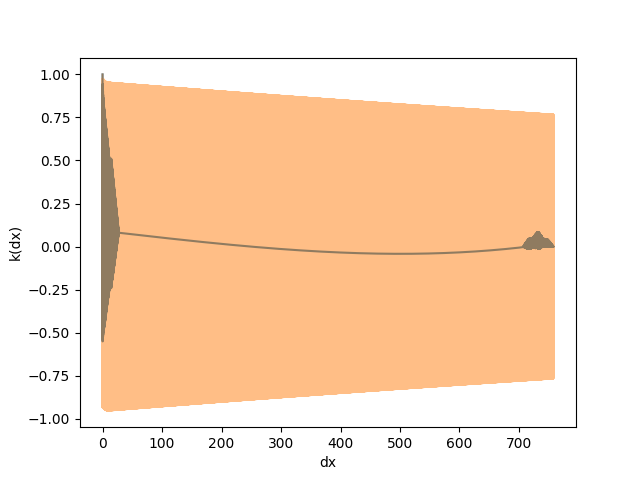

In [13]:
gp = build_gp(new_params, time)
plt.figure()
plt.plot(lag, power/power[0])
plot_kernel(gp.kernel, alpha=0.5)

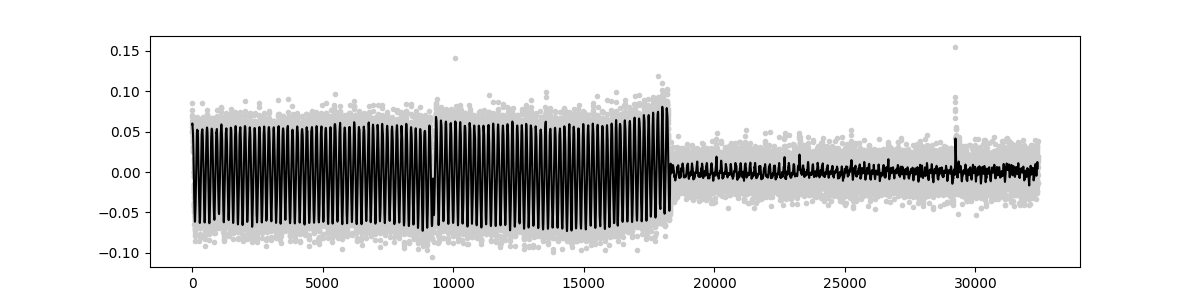

In [14]:
mu = condition(flux)
plt.figure(None, (12, 3))
plt.plot(flux, ".", c="0.8")
plt.plot(mu, c="k")

## Iterative optimization with sigclip

In [15]:
it = 3
upper_sigma = 4
lower_sigma = 3
mask = np.ones_like(time).astype(bool)
n_up = 15

for i in range(it):
    new_params = optimize_subset(new_params, time[mask], flux[mask])
    gp = build_gp(new_params, time[mask])
    r = (flux - condition(flux[mask], time)).__array__()
    mask_up = r < np.std(r[mask])*upper_sigma
    mask_down = r > - np.std(r[mask])*lower_sigma
    
    # mask around flares
    ups = np.flatnonzero(~mask_up)
    if len(ups) > 0:
        mask_up[np.hstack([np.arange(max(u-n_up, 0), min(u+n_up, len(time))) for u in ups])] = False
    mask = np.logical_and(mask_up, mask_down)

ScipyMinimizeInfo(fun_val=DeviceArray(-95813.70932176, dtype=float64, weak_type=True), success=False, status=2, iter_num=0)
ScipyMinimizeInfo(fun_val=DeviceArray(-95736.81978743, dtype=float64, weak_type=True), success=False, status=2, iter_num=20)
ScipyMinimizeInfo(fun_val=DeviceArray(-95745.47211591, dtype=float64, weak_type=True), success=True, status=0, iter_num=17)


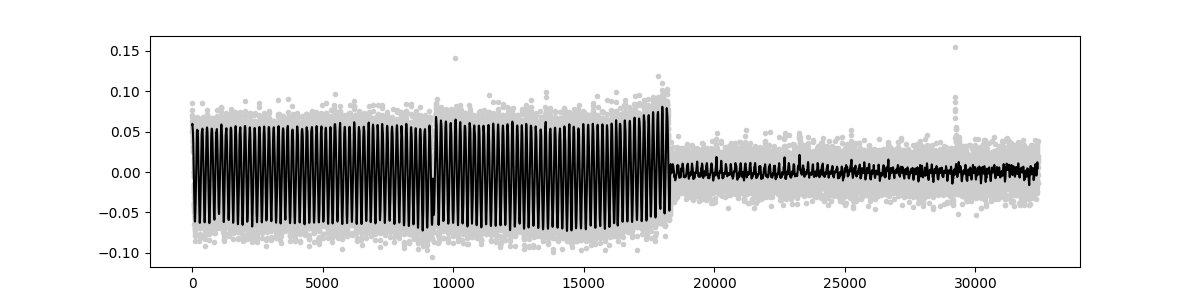

In [16]:
gp = build_gp(new_params, time[mask])
mu = condition(flux[mask], time)
plt.figure(None, (12, 3))
plt.plot(flux, ".", c="0.8")
plt.plot(mu, c="k")